In [1]:
from investesg import InvestESG
import numpy as np

# No ESG Invest; No preference for ESG; Risk free market

In [2]:
env = InvestESG(company_attributes=[{'capital':10000,'climate_risk_exposure':0.5,'beta':0},
                                    {'capital':10000,'climate_risk_exposure':0.5,'beta':0},
                                    {'capital':10000,'climate_risk_exposure':0.5,'beta':0}], 
                                    num_investors=3, initial_climate_event_probability=0.1,
                                    market_performance_baseline=1.05, market_performance_variance=0)

In [3]:
env.reset()
for i in range(100):
    # Company actions: set all values to 0
    company_actions = {
        f"company_{j}": np.array([0.0,0.0,0.0]) for j in range(env.num_companies)
    }

    # Investor actions: continuous values that sum to 1
    investor_actions = {f"investor_{i}": env.action_space(f"investor_{i}").sample() for i in range(env.num_investors)}

    # Set specific investor actions if needed
    investor_actions['investor_0'] = [1.0, 0.0, 0.0]
    investor_actions['investor_1'] = [0.0, 1.0, 0.0]
    investor_actions['investor_2'] = [0.0, 0.0, 1.0]

    actions = {**company_actions, **investor_actions}
    obs, rewards, terminations, truncations, infos = env.step(actions)

<Figure size 640x480 with 0 Axes>

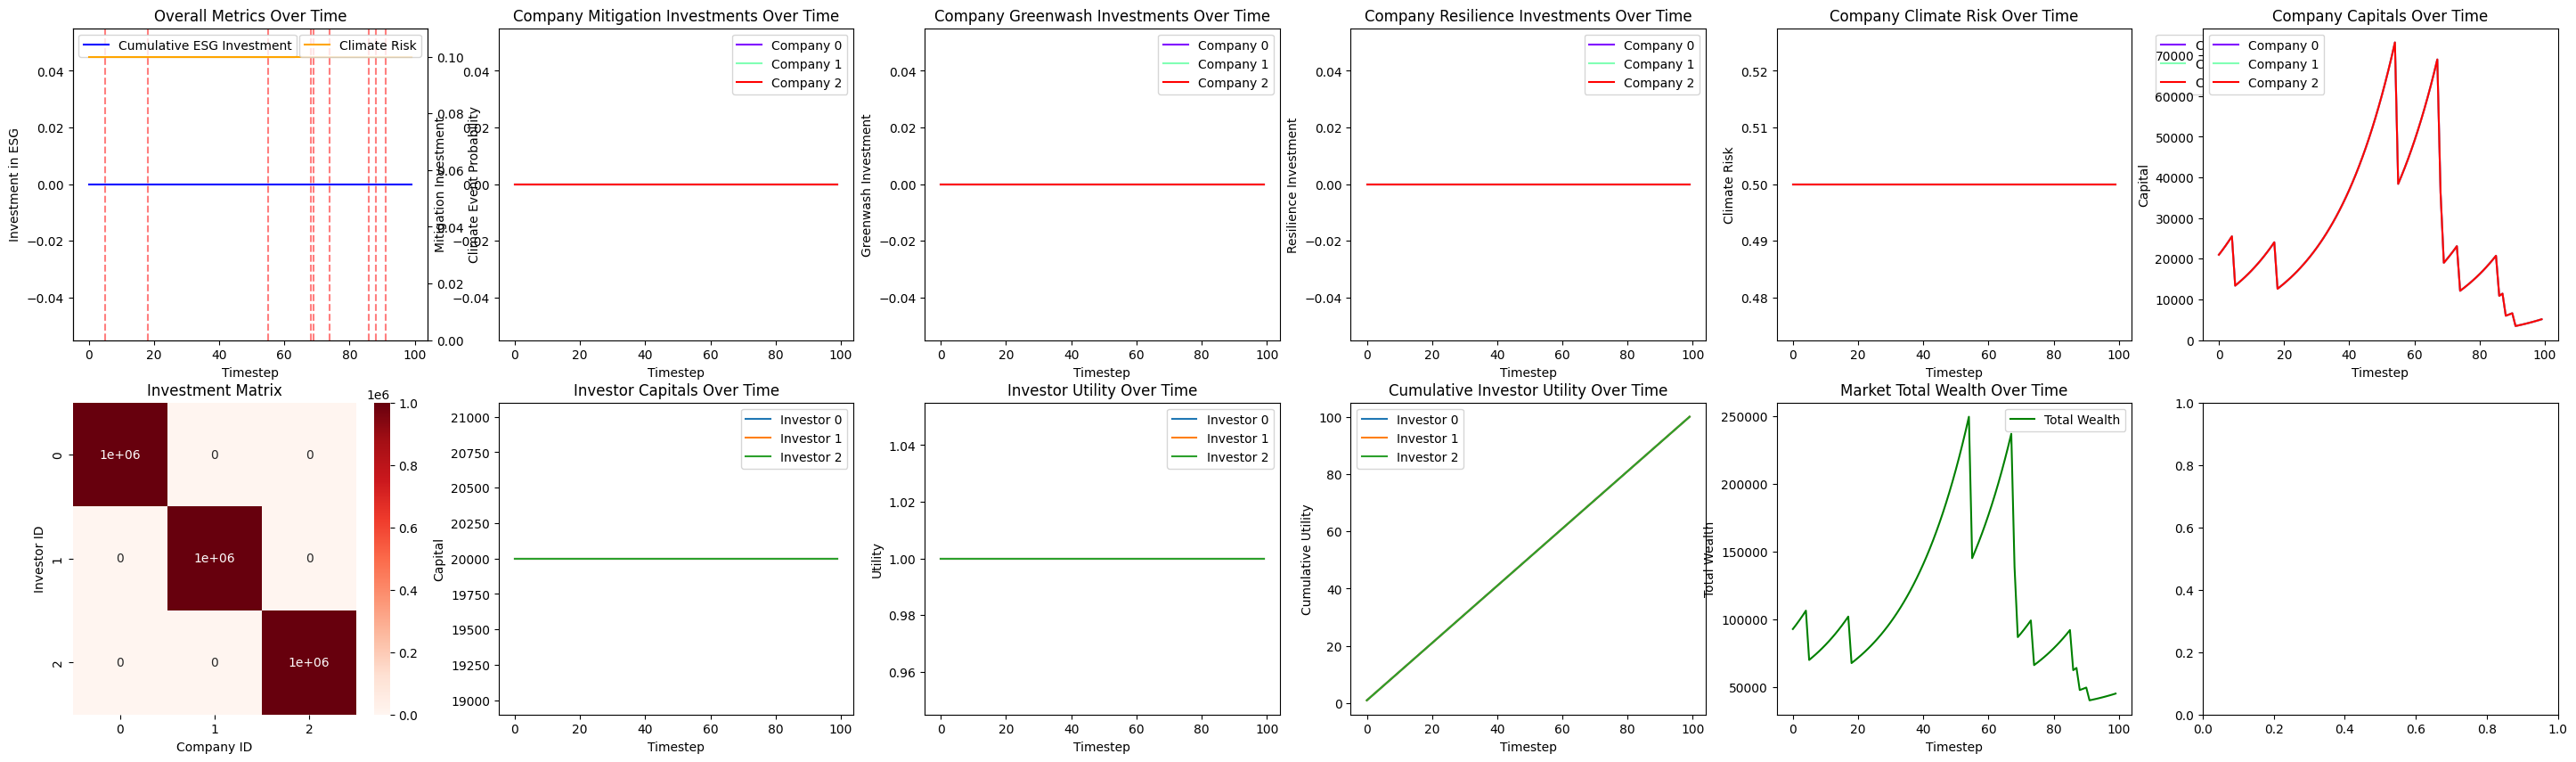

In [4]:
env.render()
env.fig

# One Company Invest in ESG every ten periods; No preference for ESG; Risk free market

<Figure size 640x480 with 0 Axes>

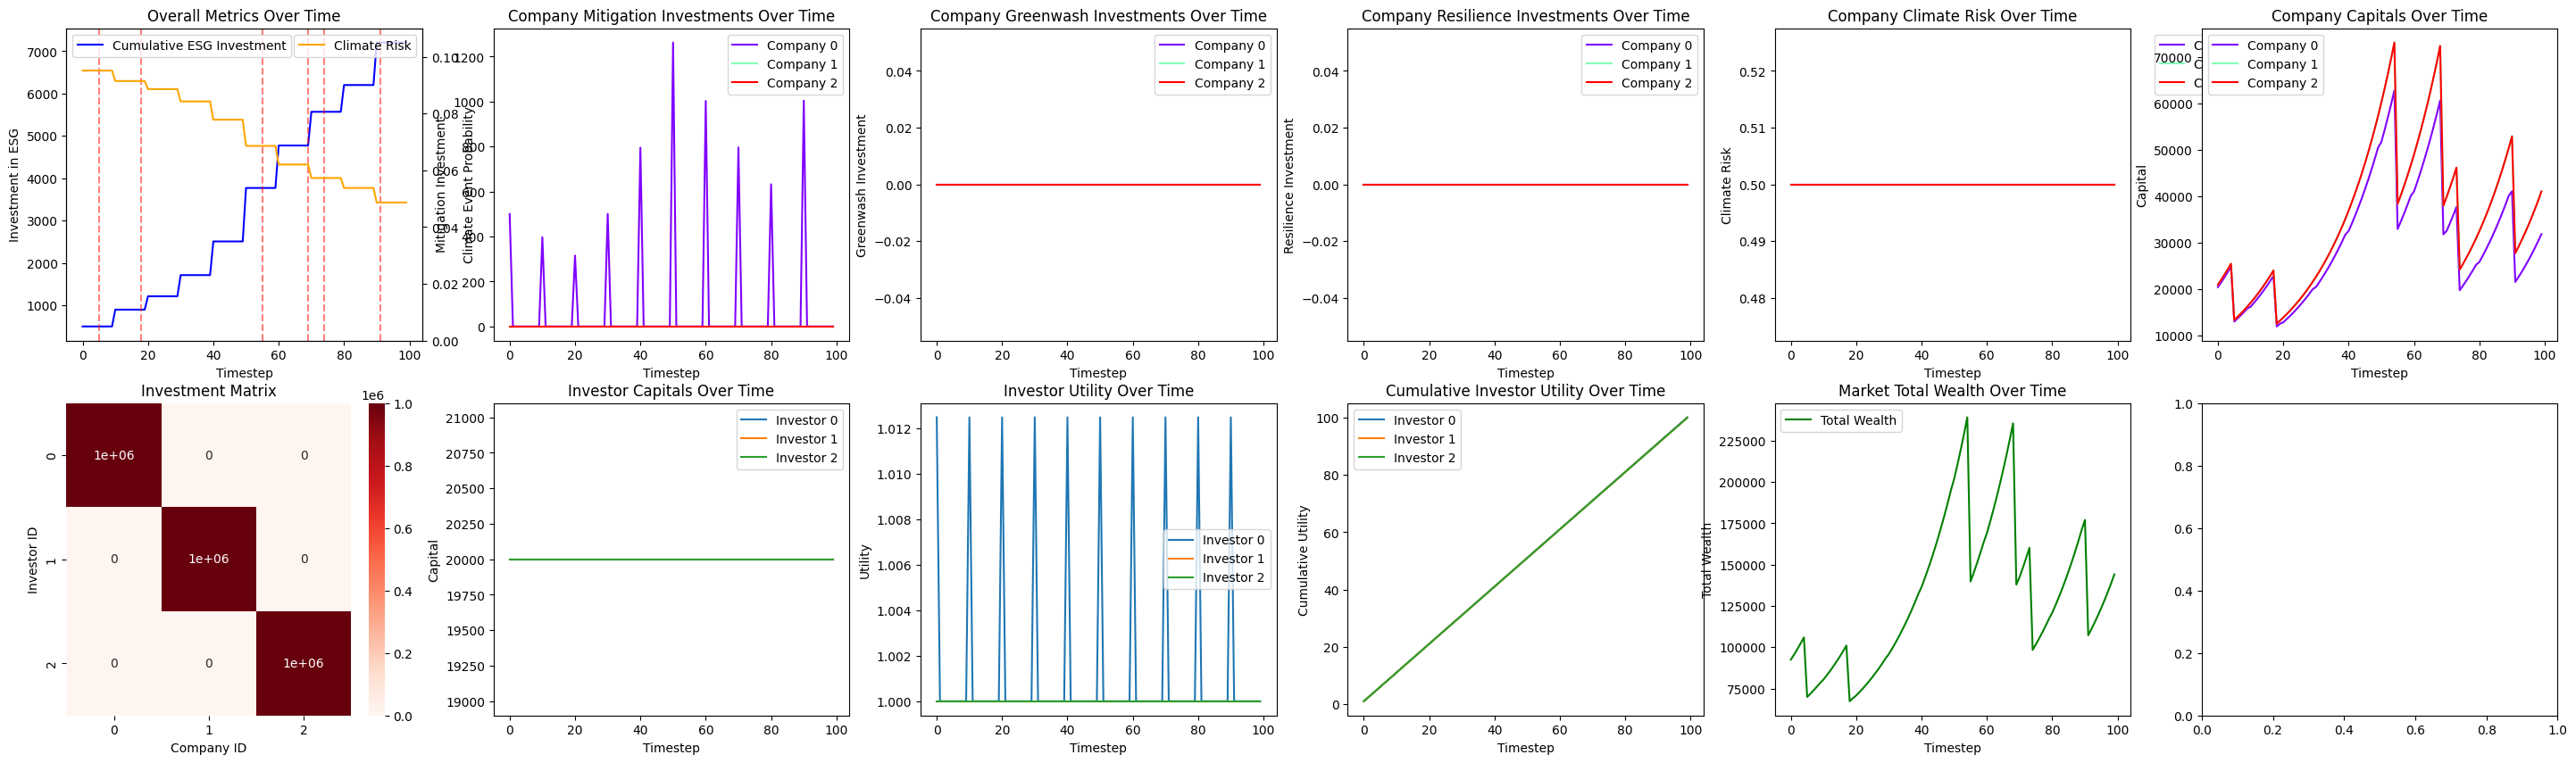

In [5]:
env = InvestESG(company_attributes=[{'capital':10000,'climate_risk_exposure':0.5,'beta':0},
                                    {'capital':10000,'climate_risk_exposure':0.5,'beta':0},
                                    {'capital':10000,'climate_risk_exposure':0.5,'beta':0}],
                investor_attributes=[{'capital':10000,'esg_preference':0.5},
                                     {'capital':10000,'esg_preference':0.5},
                                     {'capital':10000,'esg_preference':0.5}], 
                                    num_investors=3, initial_climate_event_probability=0.1,
                                    market_performance_baseline=1.05, market_performance_variance=0)

env.reset()
for i in range(100):
    company_actions = {f"company_{i}": env.action_space(f"company_{i}").sample() for i in range(env.num_companies)}
    # company invests in ESG every 10 steps, other companies never do
    if i % 10 == 0:
        company_actions['company_0'] = np.array([0.025,0,0])
    else:
        company_actions['company_0'] = np.array([0,0,0])

    company_actions['company_1'] = np.array([0,0,0])
    company_actions['company_2'] = np.array([0,0,0])
    investor_actions = {f"investor_{i}": env.action_space(f"investor_{i}").sample() for i in range(env.num_investors)}
    # mask such that investor 0 only invests in company 0
    investor_actions['investor_0'] = [1, 0, 0]
    investor_actions['investor_1'] = [0, 1, 0]
    investor_actions['investor_2'] = [0, 0, 1]
    actions = {**company_actions, **investor_actions}
    obs, rewards, terminations, truncations, infos = env.step(actions)

env.render()
env.fig

In [ ]:
env.history['market_total_wealth']

# One Company Invest in ESG every ten periods, the other one in greenwashing

<Figure size 640x480 with 0 Axes>

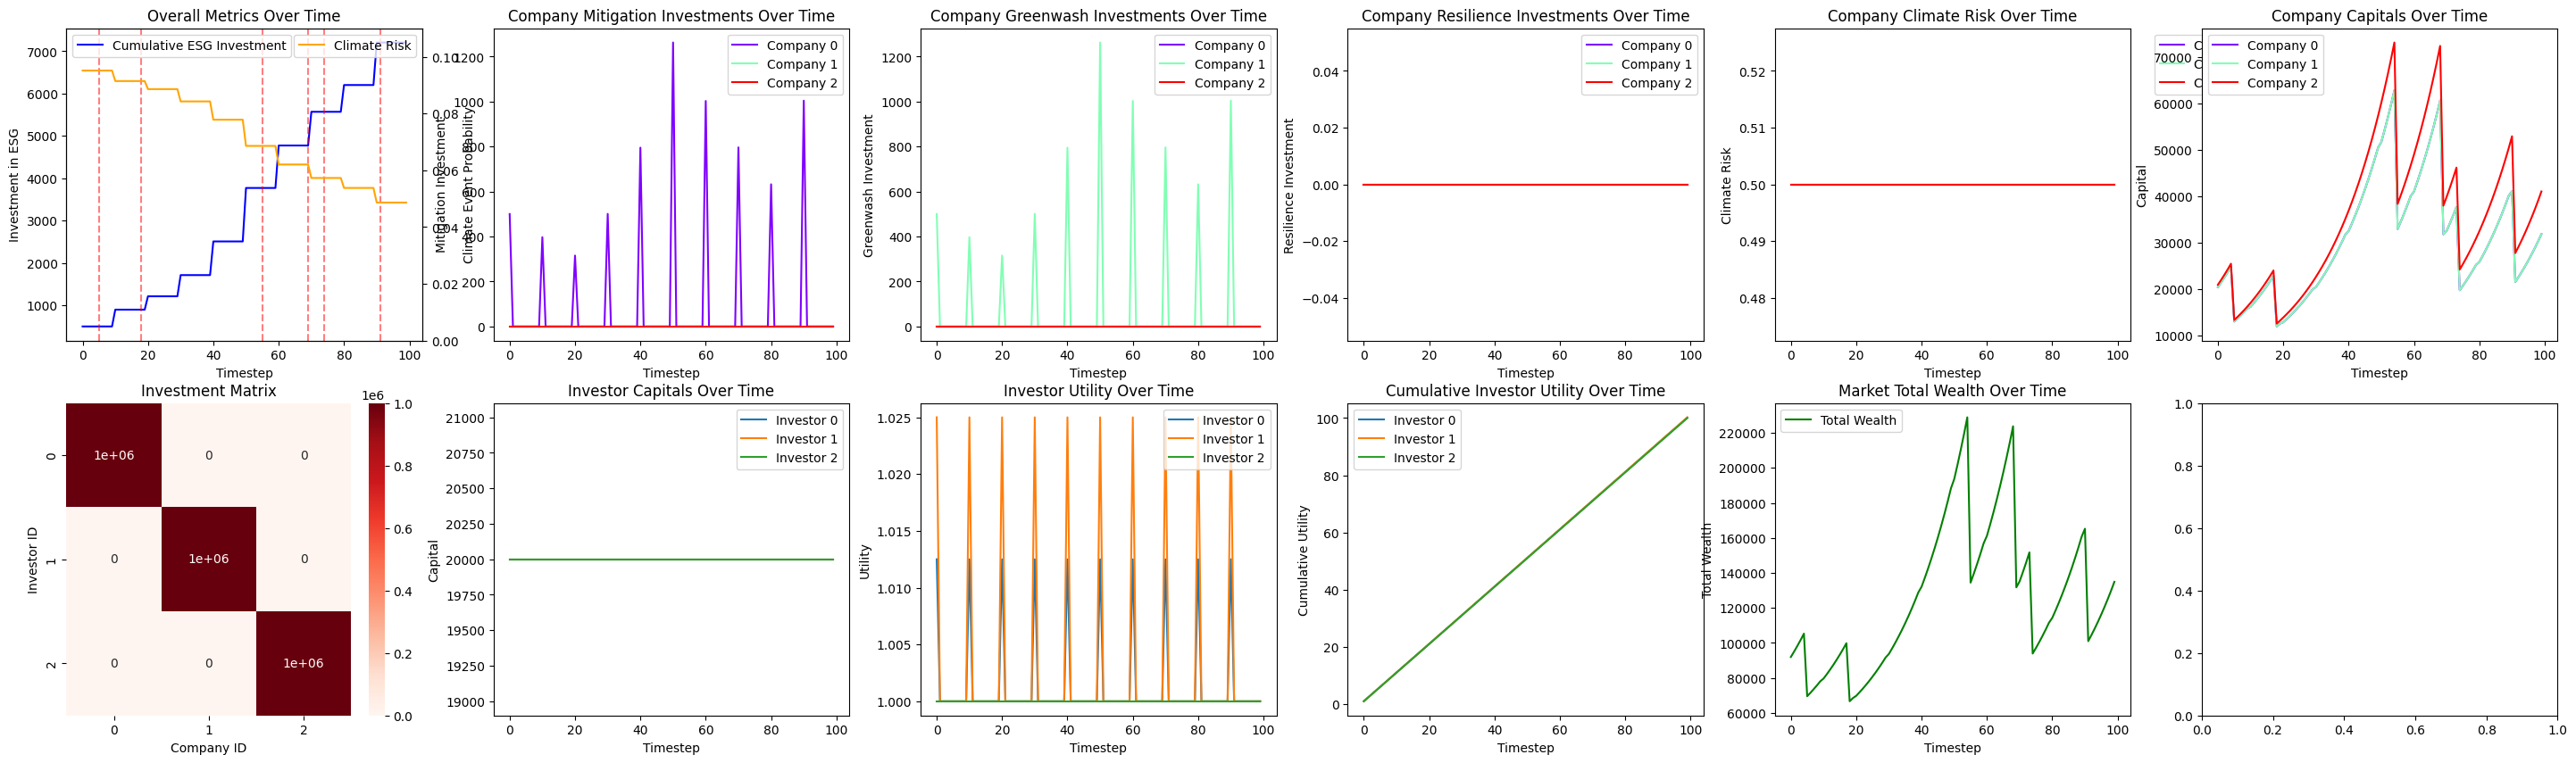

In [6]:
env = InvestESG(company_attributes=[{'capital':10000,'climate_risk_exposure':0.5,'beta':0},
                                    {'capital':10000,'climate_risk_exposure':0.5,'beta':0},
                                    {'capital':10000,'climate_risk_exposure':0.5,'beta':0}],
                investor_attributes=[{'capital':10000,'esg_preference':0.5},
                                     {'capital':10000,'esg_preference':0.5},
                                     {'capital':10000,'esg_preference':0.5}], 
                                    num_investors=3, initial_climate_event_probability=0.1,
                                    market_performance_baseline=1.05, market_performance_variance=0)

env.reset()
for i in range(100):
    company_actions = {f"company_{i}": env.action_space(f"company_{i}").sample() for i in range(env.num_companies)}
    # company invests in ESG every 10 steps, other companies never do
    if i % 10 == 0:
        company_actions['company_0'] = np.array([0.025,0,0])
    else:
        company_actions['company_0'] = np.array([0,0,0])

    # company spends on greenwashing
    if i % 10 == 0:
        company_actions['company_1'] = np.array([0,0.025,0])
    else:
        company_actions['company_1'] = np.array([0,0,0])

    company_actions['company_2'] = np.array([0,0,0])
    investor_actions = {f"investor_{i}": env.action_space(f"investor_{i}").sample() for i in range(env.num_investors)}
    # mask such that investor 0 only invests in company 0
    investor_actions['investor_0'] = [1, 0, 0]
    investor_actions['investor_1'] = [0, 1, 0]
    investor_actions['investor_2'] = [0, 0, 1]
    actions = {**company_actions, **investor_actions}
    obs, rewards, terminations, truncations, infos = env.step(actions)

env.render()
env.fig

In [ ]:
env.history['market_total_wealth'][-1]

# A pure Random Case

In [ ]:
env = InvestESG(company_attributes=[{'capital':10000,'climate_risk_exposure':0.5,'beta':0},
                                    {'capital':10000,'climate_risk_exposure':0.5,'beta':0},
                                    {'capital':10000,'climate_risk_exposure':0.5,'beta':0}],
                investor_attributes=[{'capital':10000,'esg_preference':0.5},
                                     {'capital':10000,'esg_preference':0.5},
                                     {'capital':10000,'esg_preference':0.5}], 
                                    num_investors=3, initial_climate_event_probability=0.1,
                                    market_performance_baseline=1.05, market_performance_variance=0)

env.reset()
for i in range(100):
    company_actions = {f"company_{i}": env.action_space(f"company_{i}").sample() for i in range(env.num_companies)}
    investor_actions = {f"investor_{i}": env.action_space(f"investor_{i}").sample() for i in range(env.num_investors)}
    actions = {**company_actions, **investor_actions}
    obs, rewards, terminations, truncations, infos = env.step(actions)

env.render()
env.fig